# 06 Long Run: 10K Steps at Batch 2

**Goals:**
1. Train for 10,000 steps at batch size 2 (our speed winner)
2. Track loss every step to see the full learning curve
3. Detect where learning plateaus (if it does)
4. Generate text to verify the model actually learned something

**Expected runtime:** ~2.2 minutes (75 steps/sec × 10K steps)

In [1]:
# === Parameters ===

# Architecture (from sweeps)
VOCAB_SIZE = 8192
N_EMBD = 128
N_HEAD = 2
N_LAYER = 2
N_POSITIONS = 512
N_INNER = 512

# Training
BATCH_SIZE = 2  # Speed winner from notebook 05
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
SEED = 42

# Run length
STEPS = 10_000

# Paths
DATASET_PATH = "tokenized_dataset"

In [2]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_callback import TrainerCallback

print("Imports complete.")

Imports complete.


In [3]:
# Load dataset
dataset = load_from_disk(DATASET_PATH)
print(f"Dataset: {len(dataset):,} sequences")

# Collator
class CausalLMCollator:
    def __call__(self, examples):
        input_ids = torch.tensor([ex["input_ids"] for ex in examples], dtype=torch.long)
        return {"input_ids": input_ids, "labels": input_ids.clone()}

collator = CausalLMCollator()

Dataset: 921,519 sequences


In [4]:
class DenseLossTracker(TrainerCallback):
    """Track loss at every step, not just logging steps."""
    def __init__(self):
        self.losses = []
        self.steps = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

In [5]:
# Create model
set_seed(SEED)
config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_embd=N_EMBD,
    n_head=N_HEAD,
    n_layer=N_LAYER,
    n_positions=N_POSITIONS,
    n_inner=N_INNER,
    activation_function='gelu',
    resid_pdrop=0.0,
    embd_pdrop=0.0,
    attn_pdrop=0.0,
    layer_norm_epsilon=1e-5,
    initializer_range=0.02,
    use_cache=False,
)
model = GPT2LMHeadModel(config)
n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,}")

# Training args - log every 10 steps for dense curve without too much overhead
args = TrainingArguments(
    output_dir="long_run",
    overwrite_output_dir=True,
    max_steps=STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    max_grad_norm=MAX_GRAD_NORM,
    bf16=True,
    optim="adamw_torch",
    lr_scheduler_type="linear",
    warmup_steps=0,
    logging_steps=10,  # Dense logging
    logging_first_step=True,
    report_to="none",
    save_strategy="no",
    dataloader_num_workers=0,
    seed=SEED,
)

# Train
tracker = DenseLossTracker()
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset,
    data_collator=collator,
    callbacks=[tracker],
)

print(f"\nTraining for {STEPS:,} steps...")
start = time.time()
trainer.train()
elapsed = time.time() - start

print(f"\nDone!")
print(f"Time: {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"Steps/sec: {STEPS/elapsed:.1f}")
print(f"Final loss: {tracker.losses[-1]:.4f}")

Parameters: 1,510,912

Training for 10,000 steps...


/Users/jefferyharrell/Workshop/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,9.001700
10,8.854300
20,8.584200
30,8.430500
40,8.255600
50,8.085600
60,7.925800
70,7.747500
80,7.620500
90,7.462100



Done!
Time: 139.1s (2.3 min)
Steps/sec: 71.9
Final loss: 3.7028


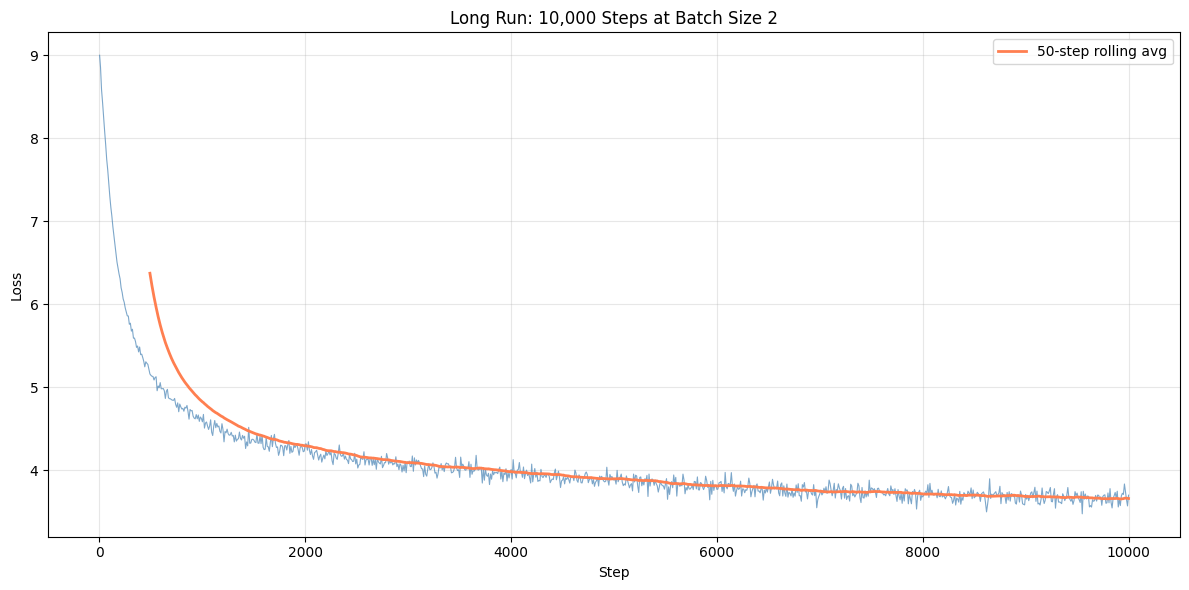

Saved: long_run_loss.png


In [6]:
# Plot the full loss curve
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(tracker.steps, tracker.losses, color='steelblue', linewidth=0.8, alpha=0.7)

# Add smoothed version
window = 50
if len(tracker.losses) > window:
    smoothed = np.convolve(tracker.losses, np.ones(window)/window, mode='valid')
    smoothed_steps = tracker.steps[window-1:]
    ax.plot(smoothed_steps, smoothed, color='coral', linewidth=2, label=f'{window}-step rolling avg')

ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title(f'Long Run: {STEPS:,} Steps at Batch Size {BATCH_SIZE}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('long_run_loss.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: long_run_loss.png")

Initial slope: -0.003321 (loss/step)
Threshold for 'flat': 0.000332
Plateau detected at step: 1990


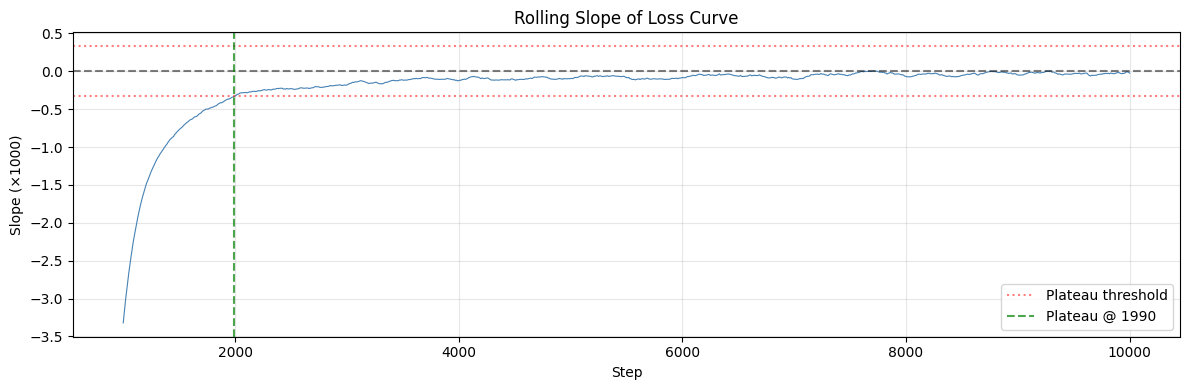

Saved: long_run_slope.png


In [7]:
# Plateau detection: where does the rolling average slope approach zero?
losses = np.array(tracker.losses)
steps = np.array(tracker.steps)

# Compute rolling slope (derivative)
window = 100
slopes = []
slope_steps = []

for i in range(window, len(losses)):
    # Linear regression over window
    x = steps[i-window:i]
    y = losses[i-window:i]
    slope = np.polyfit(x, y, 1)[0]  # slope of linear fit
    slopes.append(slope)
    slope_steps.append(steps[i])

slopes = np.array(slopes)
slope_steps = np.array(slope_steps)

# Find where slope stays near zero (within 10% of initial slope magnitude)
initial_slope = slopes[0]
threshold = abs(initial_slope) * 0.1

# Find first sustained period where |slope| < threshold
plateau_start = None
sustained_count = 0
required_sustained = 50  # Must stay flat for this many measurements

for i, (step, slope) in enumerate(zip(slope_steps, slopes)):
    if abs(slope) < threshold:
        sustained_count += 1
        if sustained_count >= required_sustained and plateau_start is None:
            plateau_start = slope_steps[i - required_sustained]
    else:
        sustained_count = 0

print(f"Initial slope: {initial_slope:.6f} (loss/step)")
print(f"Threshold for 'flat': {threshold:.6f}")
if plateau_start:
    print(f"Plateau detected at step: {plateau_start:.0f}")
else:
    print("No clear plateau detected - still learning at end of run")

# Plot slope over time
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(slope_steps, slopes * 1000, color='steelblue', linewidth=0.8)  # Scale for readability
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.axhline(y=threshold * 1000, color='red', linestyle=':', alpha=0.5, label='Plateau threshold')
ax.axhline(y=-threshold * 1000, color='red', linestyle=':', alpha=0.5)
if plateau_start:
    ax.axvline(x=plateau_start, color='green', linestyle='--', alpha=0.7, label=f'Plateau @ {plateau_start:.0f}')
ax.set_xlabel('Step')
ax.set_ylabel('Slope (×1000)')
ax.set_title('Rolling Slope of Loss Curve')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('long_run_slope.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: long_run_slope.png")

In [9]:
# Reconstruct tokenizer from token_mapping.json (created by notebook 02)
import json
from transformers import GPT2TokenizerFast

with open("token_mapping.json", "r") as f:
    mapping_data = json.load(f)

class DucklingTokenizer:
    """Reconstruct the CompactTokenizer from saved mapping."""
    def __init__(self, mapping):
        self.base_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        # Convert string keys back to ints
        self.gpt2_to_compact = {int(k): v for k, v in mapping["gpt2_to_compact"].items()}
        self.compact_to_gpt2 = {int(k): v for k, v in mapping["compact_to_gpt2"].items()}
        self.live_vocab_size = mapping["live_tokens"]
        self.unk_id = mapping["unk_id"]

    def encode(self, text):
        gpt2_ids = self.base_tokenizer.encode(text)
        return [self.gpt2_to_compact.get(id, self.unk_id) for id in gpt2_ids]

    def decode(self, ids):
        gpt2_ids = [self.compact_to_gpt2.get(id, 0) for id in ids if id in self.compact_to_gpt2]
        return self.base_tokenizer.decode(gpt2_ids)

tokenizer = DucklingTokenizer(mapping_data)
print(f"Tokenizer reconstructed from token_mapping.json")
print(f"Live vocab: {tokenizer.live_vocab_size}, UNK ID: {tokenizer.unk_id}")

Tokenizer reconstructed from token_mapping.json
Live vocab: 6144, UNK ID: 0


In [10]:
# Generation test: does the model predict sensible tokens?
model.eval()
model.config.use_cache = True  # Enable KV cache for generation

prompts = [
    "Once upon a time",
    "The little girl",
    "One day, a",
]

print("=" * 60)
print("GENERATION TEST (greedy decoding, no sampling)")
print("=" * 60)

device = next(model.parameters()).device

for prompt in prompts:
    print(f"\nPrompt: \"{prompt}\"")
    print("-" * 40)
    
    # Encode prompt
    input_ids = torch.tensor([tokenizer.encode(prompt)], device=device)
    
    # Generate (greedy)
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=50,
            do_sample=False,  # Greedy
            pad_token_id=0,
            eos_token_id=None,  # Don't stop early
        )
    
    # Decode
    generated = tokenizer.decode(output_ids[0].tolist())
    print(f"Output: {generated}")
    
    # Check for repetition
    new_tokens = output_ids[0, input_ids.shape[1]:].tolist()
    unique_tokens = len(set(new_tokens))
    print(f"[{unique_tokens} unique tokens out of {len(new_tokens)} generated]")

print("\n" + "=" * 60)

GENERATION TEST (greedy decoding, no sampling)

Prompt: "Once upon a time"
----------------------------------------
Output: Once upon a time, there was a little girl named Lily. She loved to play with her mommy. She loved to play with her mommy. She loved to play with her mommy and her mommy and her mommy and her mommy and her mom
[18 unique tokens out of 50 generated]

Prompt: "The little girl"
----------------------------------------
Output: The little girl was so happy to play with her mommy.


The little girl was so happy that she was so happy that she was so happy that she was so happy that she was so happy that she was so happy.


The little
[16 unique tokens out of 50 generated]

Prompt: "One day, a"
----------------------------------------
Output: One day, a big, a big, a big, a big, the park. The little girl was very happy. She was very happy.

The little girl was very happy. She was very happy. She was so happy. She was so happy.
[16 unique tokens out of 50 generated]



## Conclusion

Questions answered:

1. **Does loss keep dropping for 10K steps?**
2. **Where does it plateau (if at all)?**
3. **Does the model generate sensible text or garbage?**

If the model generates repetitive garbage, it hasn't really learned—the loss curve is misleading. If it generates varied, vaguely story-like text, it's actually learning language structure.